# SVM Tuning (Descriptors + Fingerprints)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)

from sklearn.svm import SVC
import shap
import optuna

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor + Fingerprints and Outlier Functions


In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog("rdApp.*")
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(
        mol, nBits=tt_bits
    )
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog("rdApp.*")

    return feats

## Dataset Processing


In [ ]:
# Configuration
ORIG_DATASET = "in_vivo_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_vivo_dataset_processed.xlsx"
# Outputs
TRAIN_X_CSV = "in_vivo_x_train.csv"
TEST_X_CSV = "in_vivo_x_test.csv"
TRAIN_Y_CSV = "in_vivo_y_train.csv"
TEST_Y_CSV = "in_vivo_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    fp_feats = calculate_fingerprints(molecule)

    # Merge both dicts into one feature row
    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)], axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
# Splitting the dataset to Fingerprint and Descriptor sets
FP_PREFIXES = (
    "Morgan",
    "RDK_",
    "MACCS",
    "AtomPair_",
    "Torsion_",
)  # Identify fingerprint columns by prefix
fp_cols = [c for c in X_train.columns if c.startswith(FP_PREFIXES)]
desc_cols = [c for c in X_train.columns if c not in fp_cols]

print(f"Descriptor columns: {len(desc_cols)}, fingerprint columns: {len(fp_cols)}")

scaler = StandardScaler()
if desc_cols:
    X_train_desc_scaled = scaler.fit_transform(X_train[desc_cols])
    X_test_desc_scaled = scaler.transform(X_test[desc_cols])

    # Start from copies so we keep original indexing and all columns
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Overwrite only descriptor columns with scaled values
    X_train_scaled[desc_cols] = X_train_desc_scaled
    X_test_scaled[desc_cols] = X_test_desc_scaled
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

X_train = X_train_scaled
X_test = X_test_scaled

# Save processed datasets
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 35/Columns: 8585
                       Name                                                                                                                                         IUPAC name CAS registry number      Structure  Phototoxicity                                                                             SMILES code                                          Sources  Note  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ     BertzCT      Chi0     Chi0n     Chi0v      Chi1     Chi1n     Chi1v     Chi2n     Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha          Ipc    Kappa1    Ka

## Base Model Train


In [4]:
# SVM pipeline: scale features + RBF-kernel SVM with calibrated probabilities
base_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance (SVM):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance (SVM):
Accuracy:  0.2857
Precision: 0.4000
Recall:    0.5000
F1 score:  0.4444
ROC AUC:   0.3333

Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.400     0.500     0.444         4

    accuracy                          0.286         7
   macro avg      0.200     0.250     0.222         7
weighted avg      0.229     0.286     0.254         7



## Feature Selection


/tmp/ipykernel_179339/2953739021.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


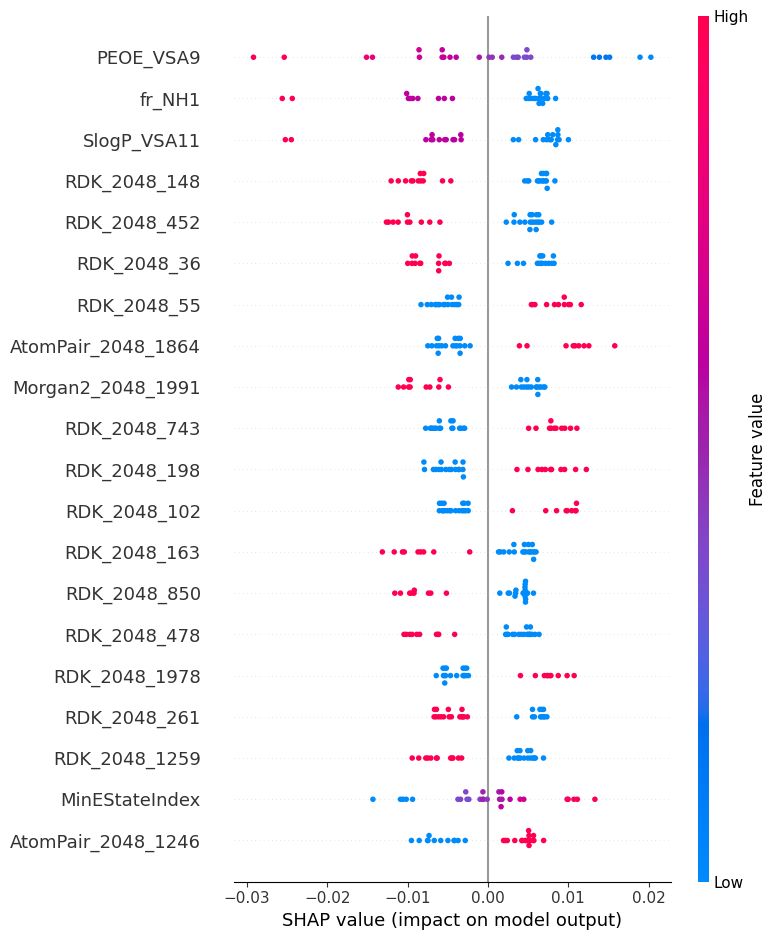


Top 10 SHAP features:
PEOE_VSA9             0.009152
fr_NH1                0.008169
SlogP_VSA11           0.007918
RDK_2048_148          0.007481
RDK_2048_452          0.006955
RDK_2048_36           0.006892
RDK_2048_55           0.006622
AtomPair_2048_1864    0.006560
Morgan2_2048_1991     0.006555
RDK_2048_743          0.006496

Top 10 K-Best features:
PEOE_VSA9            14.363126
fr_NH1                6.493320
MinEStateIndex        5.996807
RDK_2048_148          5.462185
SlogP_VSA11           5.346121
RDK_2048_452          5.217343
RDK_2048_36           3.663579
Morgan2_2048_1991     3.348089
RDK_2048_850          3.201970
RDK_2048_163          3.201970

Top 10 Lasso features:
fr_NH1                1.330435
SlogP_VSA11           1.017656
PEOE_VSA9             0.621710
AtomPair_2048_1864    0.600451
AtomPair_2048_852     0.372668
RDK_2048_55           0.327451
Morgan2_2048_80       0.305968
RDK_2048_25           0.285166
RDK_2048_198          0.255417
RDK_2048_61           0.16841

In [5]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k="all")
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

## SHAP Features


In [6]:
shap_features.head(20)

PEOE_VSA9             0.009152
fr_NH1                0.008169
SlogP_VSA11           0.007918
RDK_2048_148          0.007481
RDK_2048_452          0.006955
RDK_2048_36           0.006892
RDK_2048_55           0.006622
AtomPair_2048_1864    0.006560
Morgan2_2048_1991     0.006555
RDK_2048_743          0.006496
RDK_2048_198          0.006155
RDK_2048_102          0.005845
RDK_2048_163          0.005767
RDK_2048_850          0.005654
RDK_2048_478          0.005589
RDK_2048_1978         0.005428
RDK_2048_261          0.005421
RDK_2048_1259         0.005281
MinEStateIndex        0.005260
AtomPair_2048_1246    0.005182
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.720000  0.706667    0.850000
1      6     0.720000  0.706667    0.777778
2      7     0.686667  0.710000    0.813889
3      8     0.720000  0.757619    0.825000
4      9     0.760000  0.767619    0.852778

Best number of features by CV F1: 41
Top_N          41.000000
CV_Accuracy     0.780000
CV_F1           0.826190
CV_ROC_AUC      0.816667
Name: 36, dtype: float64


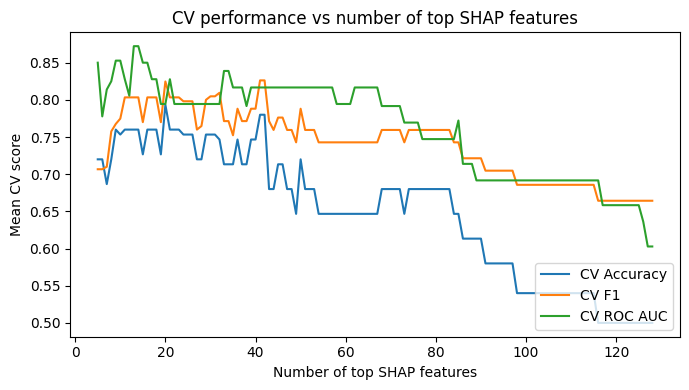

In [7]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1):
    top_feats = shap_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features


In [8]:
kbest_features.head(20)

PEOE_VSA9             14.363126
fr_NH1                 6.493320
MinEStateIndex         5.996807
RDK_2048_148           5.462185
SlogP_VSA11            5.346121
RDK_2048_452           5.217343
RDK_2048_36            3.663579
Morgan2_2048_1991      3.348089
RDK_2048_850           3.201970
RDK_2048_163           3.201970
MaxAbsEStateIndex      3.158398
RDK_2048_261           2.813853
RDK_2048_52            2.813853
MolWt                  2.648553
RDK_2048_275           2.363636
RDK_2048_170           2.333510
RDK_2048_0             2.333510
AtomPair_2048_1864     2.333510
RDK_2048_102           2.333510
RDK_2048_483           2.058080
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.720000  0.716190    0.872222
1      6     0.720000  0.706667    0.791667
2      7     0.720000  0.706667    0.688889
3      8     0.720000  0.706667    0.758333
4      9     0.753333  0.760000    0.725000

Best number of features by CV F1: 44
Top_N          44.000000
CV_Accuracy     0.786667
CV_F1           0.800000
CV_ROC_AUC      0.794444
Name: 39, dtype: float64


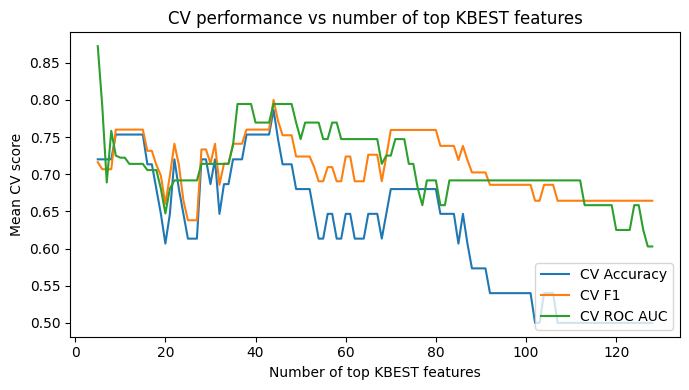

In [9]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1):
    top_feats = kbest_features.head(n).index

    # model = xgb.XGBClassifier(
    #     objective="binary:logistic", eval_metric=["logloss", "auc"], random_state=42
    # )

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features


In [10]:
lasso_features.head(20)

fr_NH1                1.330435
SlogP_VSA11           1.017656
PEOE_VSA9             0.621710
AtomPair_2048_1864    0.600451
AtomPair_2048_852     0.372668
RDK_2048_55           0.327451
Morgan2_2048_80       0.305968
RDK_2048_25           0.285166
RDK_2048_198          0.255417
RDK_2048_61           0.168416
RDK_2048_452          0.159904
RDK_2048_223          0.136215
RDK_2048_2046         0.125056
RDK_2048_1776         0.080857
EState_VSA5           0.035445
BCUT2D_MWHI           0.022842
SlogP_VSA8            0.000000
SlogP_VSA10           0.000000
EState_VSA6           0.000000
EState_VSA7           0.000000
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.753333  0.804762    0.855556
1      6     0.826667  0.882540    0.944444
2      7     0.826667  0.871429    0.941667
3      8     0.860000  0.892857    0.966667
4      9     0.826667  0.871429    0.975000

Best number of features by CV F1: 8
Top_N          8.000000
CV_Accuracy    0.860000
CV_F1          0.892857
CV_ROC_AUC     0.966667
Name: 3, dtype: float64


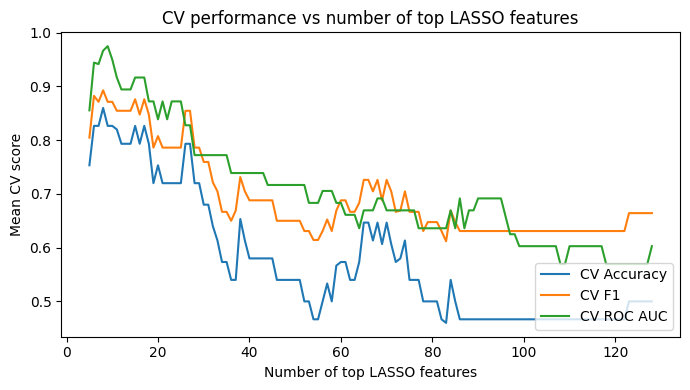

In [11]:
results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1):
    top_feats = lasso_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features


In [12]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.5714
Precision: 0.6667
Recall:    0.5000
F1 score:  0.5714
ROC AUC:   0.3333


## Model KBEST Features


In [13]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.5714
Precision: 0.6667
Recall:    0.5000
F1 score:  0.5714
ROC AUC:   0.3333


## Model LASSO Features


In [14]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.2857
Precision: 0.4000
Recall:    0.5000
F1 score:  0.4444
ROC AUC:   0.4167


## Model SHAP Features Tuning


In [15]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 86. Best value: 0.966667: 100%|██████████| 200/200 [00:06<00:00, 32.89it/s]


Best trial:
  Value: 0.9666666666666666
  Params:
    kernel: sigmoid
    C: 0.08548695023127532
    class_weight: balanced
    shrinking: False
    tol: 0.000183265732561573
    max_iter: 2000
    gamma_mode: float
    gamma: 0.2294403857156175
    coef0: 0.2653751152522941

Final Optuna model (SHAP):
Accuracy:  0.2857
Precision: 0.3333
Recall:    0.2500
F1 score:  0.2857
ROC AUC:   0.2500


## Model KBEST Features Tuning


In [16]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 138. Best value: 0.838095: 100%|██████████| 200/200 [00:06<00:00, 31.83it/s]


Best trial:
  Value: 0.8380952380952381
  Params:
    kernel: linear
    C: 0.01045765027859041
    class_weight: None
    shrinking: True
    tol: 0.0011369852247122855
    max_iter: 2000
    gamma_mode: float
    gamma: 0.09063623808195677

Final Optuna model (KBEST):
Accuracy:  0.2857
Precision: 0.3333
Recall:    0.2500
F1 score:  0.2857
ROC AUC:   0.2500


## Model LASSO Features Tuning


In [17]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 19. Best value: 1: 100%|██████████| 200/200 [00:05<00:00, 38.78it/s]     


Best trial:
  Value: 1.0
  Params:
    kernel: poly
    C: 0.17105450279987527
    class_weight: None
    shrinking: False
    tol: 0.0003751103041976217
    max_iter: -1
    gamma_mode: auto
    degree: 2
    coef0: 0.4170817212525155

Final Optuna model (LASSO):
Accuracy:  0.4286
Precision: 0.5000
Recall:    0.7500
F1 score:  0.6000
ROC AUC:   0.3333


## Model SHAP Features Tuning (Randomized Search CV)


/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



=== Testing top 5 features ===
Best parameters: {'tol': np.float64(0.005689866029018293), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.75), 'class_weight': 'balanced', 'C': np.float64(0.052310993080562605)}
Accuracy: 0.429 | ROC-AUC: 0.833

=== Testing top 6 features ===
Best parameters: {'tol': np.float64(0.005689866029018293), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.06517339604882427), 'degree': 5, 'coef0': np.float64(0.75), 'class_weight': 'balanced', 'C': np.float64(0.052310993080562605)}
Accuracy: 0.429 | ROC-AUC: 0.833

=== Testing top 7 features ===
Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(2.9673024081888726), 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.05607169938205458)}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing to

/home/samuel/Desktop/7thSemester/ToxiPred/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.003727593720314938), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0008504489341802677), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(47.13753134116719)}
Accuracy: 0.429 | ROC-AUC: 0.583

=== Testing top 20 features ===
Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.0021461411978584057), 'degree': 5, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.002300430119772917)}
Accuracy: 0.571 | ROC-AUC: 0.417

=== Testing top 21 features ===
Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.286 | ROC-AUC: 0.417

=== Testing top 22 features ===
Best parameters: {'tol': np.float

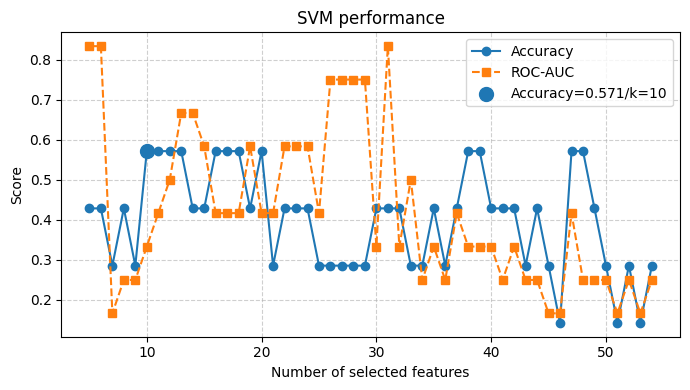


Accuracy = 0.571 | ROC-AUC = 0.333 | k = 10


In [18]:
ranking = shap_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)



=== Testing top 5 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.571 | ROC-AUC: 0.250

=== Testing top 6 features ===
Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.429 | ROC-AUC: 0.833

=== Testing top 7 features ===
Best parameters: {'tol': np.float64(0.00016768329368110083), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.025826187606826773), 'degree': 2, 'coef0': np.float64(0.1), 'class_weight': None, 'C': np.float64(0.005672426068491977)}
Accuracy: 0.571 | ROC-AUC: 0.167

=== Testing top 8 features 

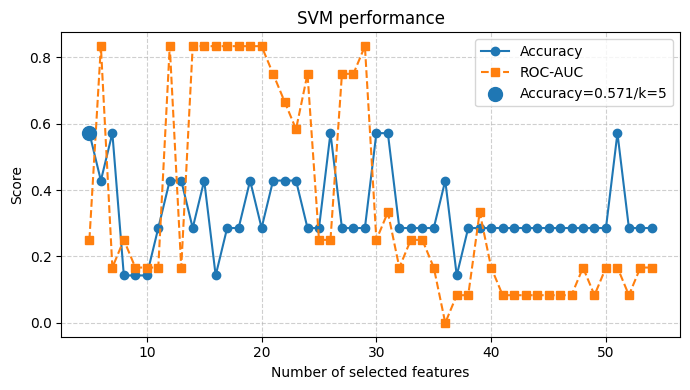


Accuracy = 0.571 | ROC-AUC = 0.250 | k = 5


In [19]:
ranking = kbest_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)



=== Testing top 5 features ===
Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.429 | ROC-AUC: 0.333

=== Testing top 6 features ===
Best parameters: {'tol': np.float64(0.0009102981779915217), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.10353218432956626), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': None, 'C': np.float64(4.150404757850472)}
Accuracy: 0.429 | ROC-AUC: 0.333

=== Testing top 7 features ===
Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.17426333860096507), 'degree': 2, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(58.05225516094895)}
Accuracy: 0.286 | ROC-AUC: 0.500

=== Testin

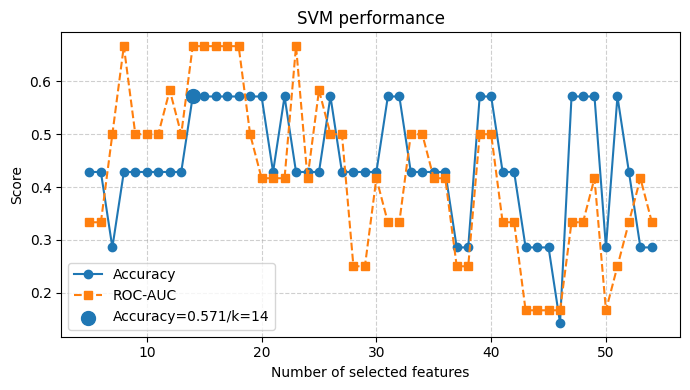


Accuracy = 0.571 | ROC-AUC = 0.667 | k = 14


In [20]:
ranking = lasso_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")